# Analysis of the flow past a 3D cylinder at $Re=3900$

In [2]:
import sys
import torch as pt
import numpy as np
from scipy.signal import welch
from bisect import bisect_left
import matplotlib.pyplot as plt
from os import makedirs, environ
from os.path import join
from copy import deepcopy
from collections import defaultdict
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, environ.get("FLOWTORCH_INSTALL_DIR"))
from flowtorch.data import mask_box
from flowtorch.analysis import SVD, LinearModel, DMD
from pydmd import BOPDMD
from IPython.display import clear_output

plt.rcParams["figure.dpi"] = 160
plt.rcParams["text.usetex"] = True
source = environ.get("CYLINDER_3D_DATA_DIR")
output = join("output", "cylinder_3D_Re3900")
makedirs(output, exist_ok=True)

In [3]:
U_REF = 39.0 # inlet velocity in [m/s]
L_REF = 0.1 # cylinder diameter in [m]
T_REF = L_REF / U_REF # convective time scale

In [4]:
coeffs = pt.load(join(source, "coeffs_probes.pt"), weights_only=False)["forces"]
coeffs.head()

,t,cx,cy
0,0.00001,2.597066,-0.011469
1,0.00002,1.570664,0.005424
2,0.00003,1.132900,-0.000045
3,0.00004,0.930115,-0.000016
4,0.00005,0.826353,-0.000010


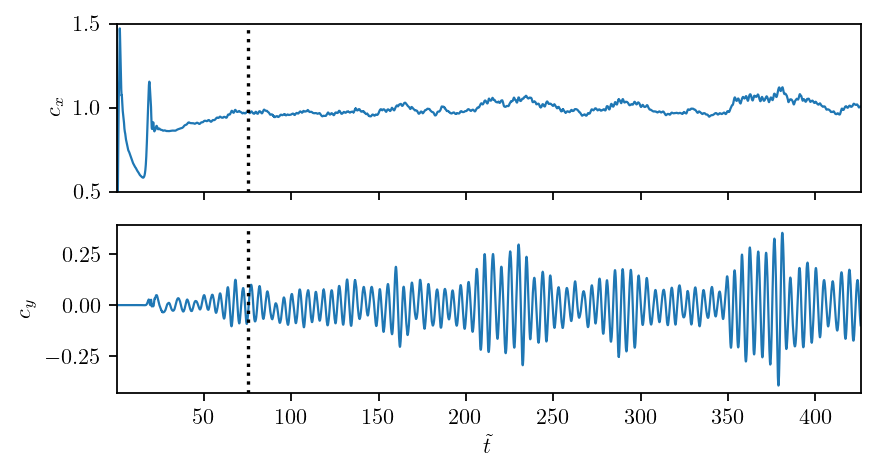

In [5]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 3), sharex=True)

t_norm = coeffs.t.values / T_REF
ax1.plot(t_norm, coeffs.cx, lw=1)
ax2.plot(t_norm, coeffs.cy, lw=1)
ax2.set_xlabel(r"$\tilde{t}$")
ax1.set_ylabel(r"$c_x$")
ax2.set_ylabel(r"$c_y$")
ax2.set_xlim(t_norm[0], t_norm[-1])
ax1.set_ylim(0.5, 1.5)
ax1.axvline(75, ls=":", c="k")
ax2.axvline(75, ls=":", c="k")
plt.show()

In [6]:
start_idx = bisect_left(t_norm, 75)
start_idx, t_norm[start_idx]

(19230, 75.0009)

In [7]:
fs = 1.0 / ((t_norm[1] - t_norm[0]) * T_REF)
cx = coeffs.cx.values[start_idx:]
cy = coeffs.cy.values[start_idx:]
fx, psd_x = welch(cx, fs=fs, window="boxcar", nperseg=len(cx), nfft=len(cx))
fy, psd_y = welch(cy, fs=fs, window="boxcar", nperseg=len(cy), nfft=len(cy))

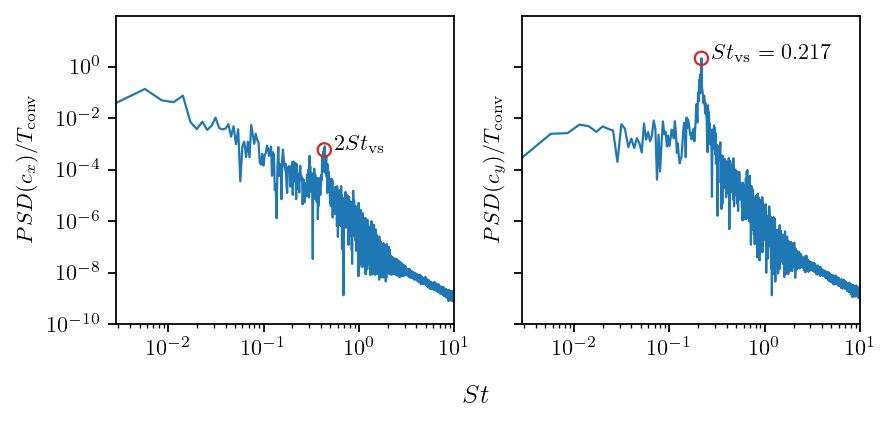

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True, sharey=True)

vs_idx = np.argmax(psd_y)
vs2_idx = np.argmin(np.absolute(fx-2*fy[vs_idx]))
ax1.plot(fx*T_REF, psd_x/T_REF, lw=1)
ax2.plot(fy*T_REF, psd_y/T_REF, lw=1)
ax2.scatter([fy[vs_idx]*T_REF], [psd_y[vs_idx]/T_REF], marker="o", facecolor="none", edgecolor="C3", zorder=7)
ax2.text(fy[vs_idx]*T_REF*1.3, psd_y[vs_idx]/T_REF, rf"$St_{{\mathrm{{vs}}}}={fy[vs_idx]*T_REF:1.3f}$")
ax1.scatter([fx[vs2_idx]*T_REF], [psd_x[vs2_idx]/T_REF], marker="o", facecolor="none", edgecolor="C3", zorder=7)
ax1.text(fx[vs2_idx]*T_REF*1.3, psd_x[vs2_idx]/T_REF, r"$2St_{\mathrm{vs}}$")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim(fx[1]*T_REF, 10)
ax1.set_ylim(1e-10)
fig.supxlabel(r"$St$", y=-0.1)
ax1.set_ylabel(r"$PSD(c_x)/T_\mathrm{conv}$")
ax2.set_ylabel(r"$PSD(c_y)/T_\mathrm{conv}$")
plt.show()

In [25]:
slice_extra = pt.load(join(source, "write_times_vertices_weights.pt"), weights_only=False)
vert = slice_extra["vertices"]
area = slice_extra["weights"]
times = slice_extra["write_times"]
times = pt.tensor([float(t) for t in times])
times = times - times[0]
del slice_extra

In [10]:
mask = mask_box(vert[:, :2], [0.8-2*L_REF, 1.0-2*L_REF], [0.8+8*L_REF, 1.0+2*L_REF])
n_points, total = mask.sum().item(), len(mask)
n_points, total, n_points/total*100

(81690, 188320, 43.378292268479186)

In [30]:
dm = pt.load(join(source, "U_plane_xy.pt"), weights_only=False).type(pt.float32)[mask]
dm = pt.cat((dm[:,0], dm[:, 1]), dim=0)
dm_mean = dm.mean(dim=1)
dm -= dm_mean.unsqueeze(-1)
dm *= area[mask].unsqueeze(-1).repeat((2, 1))
dm.shape

torch.Size([163380, 3601])

In [31]:
svd = SVD(dm, rank=100)
print(svd)

SVD of a 163380x3601 data matrix
Selected/optimal rank: 100/1403
data type: torch.float32 (4b)
truncated SVD size: 63.6986Mb


In [32]:
x, y = vert[mask][:, 0], vert[mask][:, 1]
def add_contour(ax, field, vmin, vmax, cmap="PRGn", every=1):
    levels = pt.linspace(vmin, vmax, 240)
    cont = ax.tricontourf(x[::every], y[::every], field[::every], levels=levels, vmin=vmin, vmax=vmax, cmap=cmap, extend="both")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(0.8-2*L_REF, 0.8+8*L_REF)
    ax.set_ylim(1.0-2*L_REF, 1.0+2*L_REF)
    ax.add_patch(plt.Circle((0.8, 1.0), 0.05, color='k'))
    ax.set_aspect("equal", 'box')
    return cont

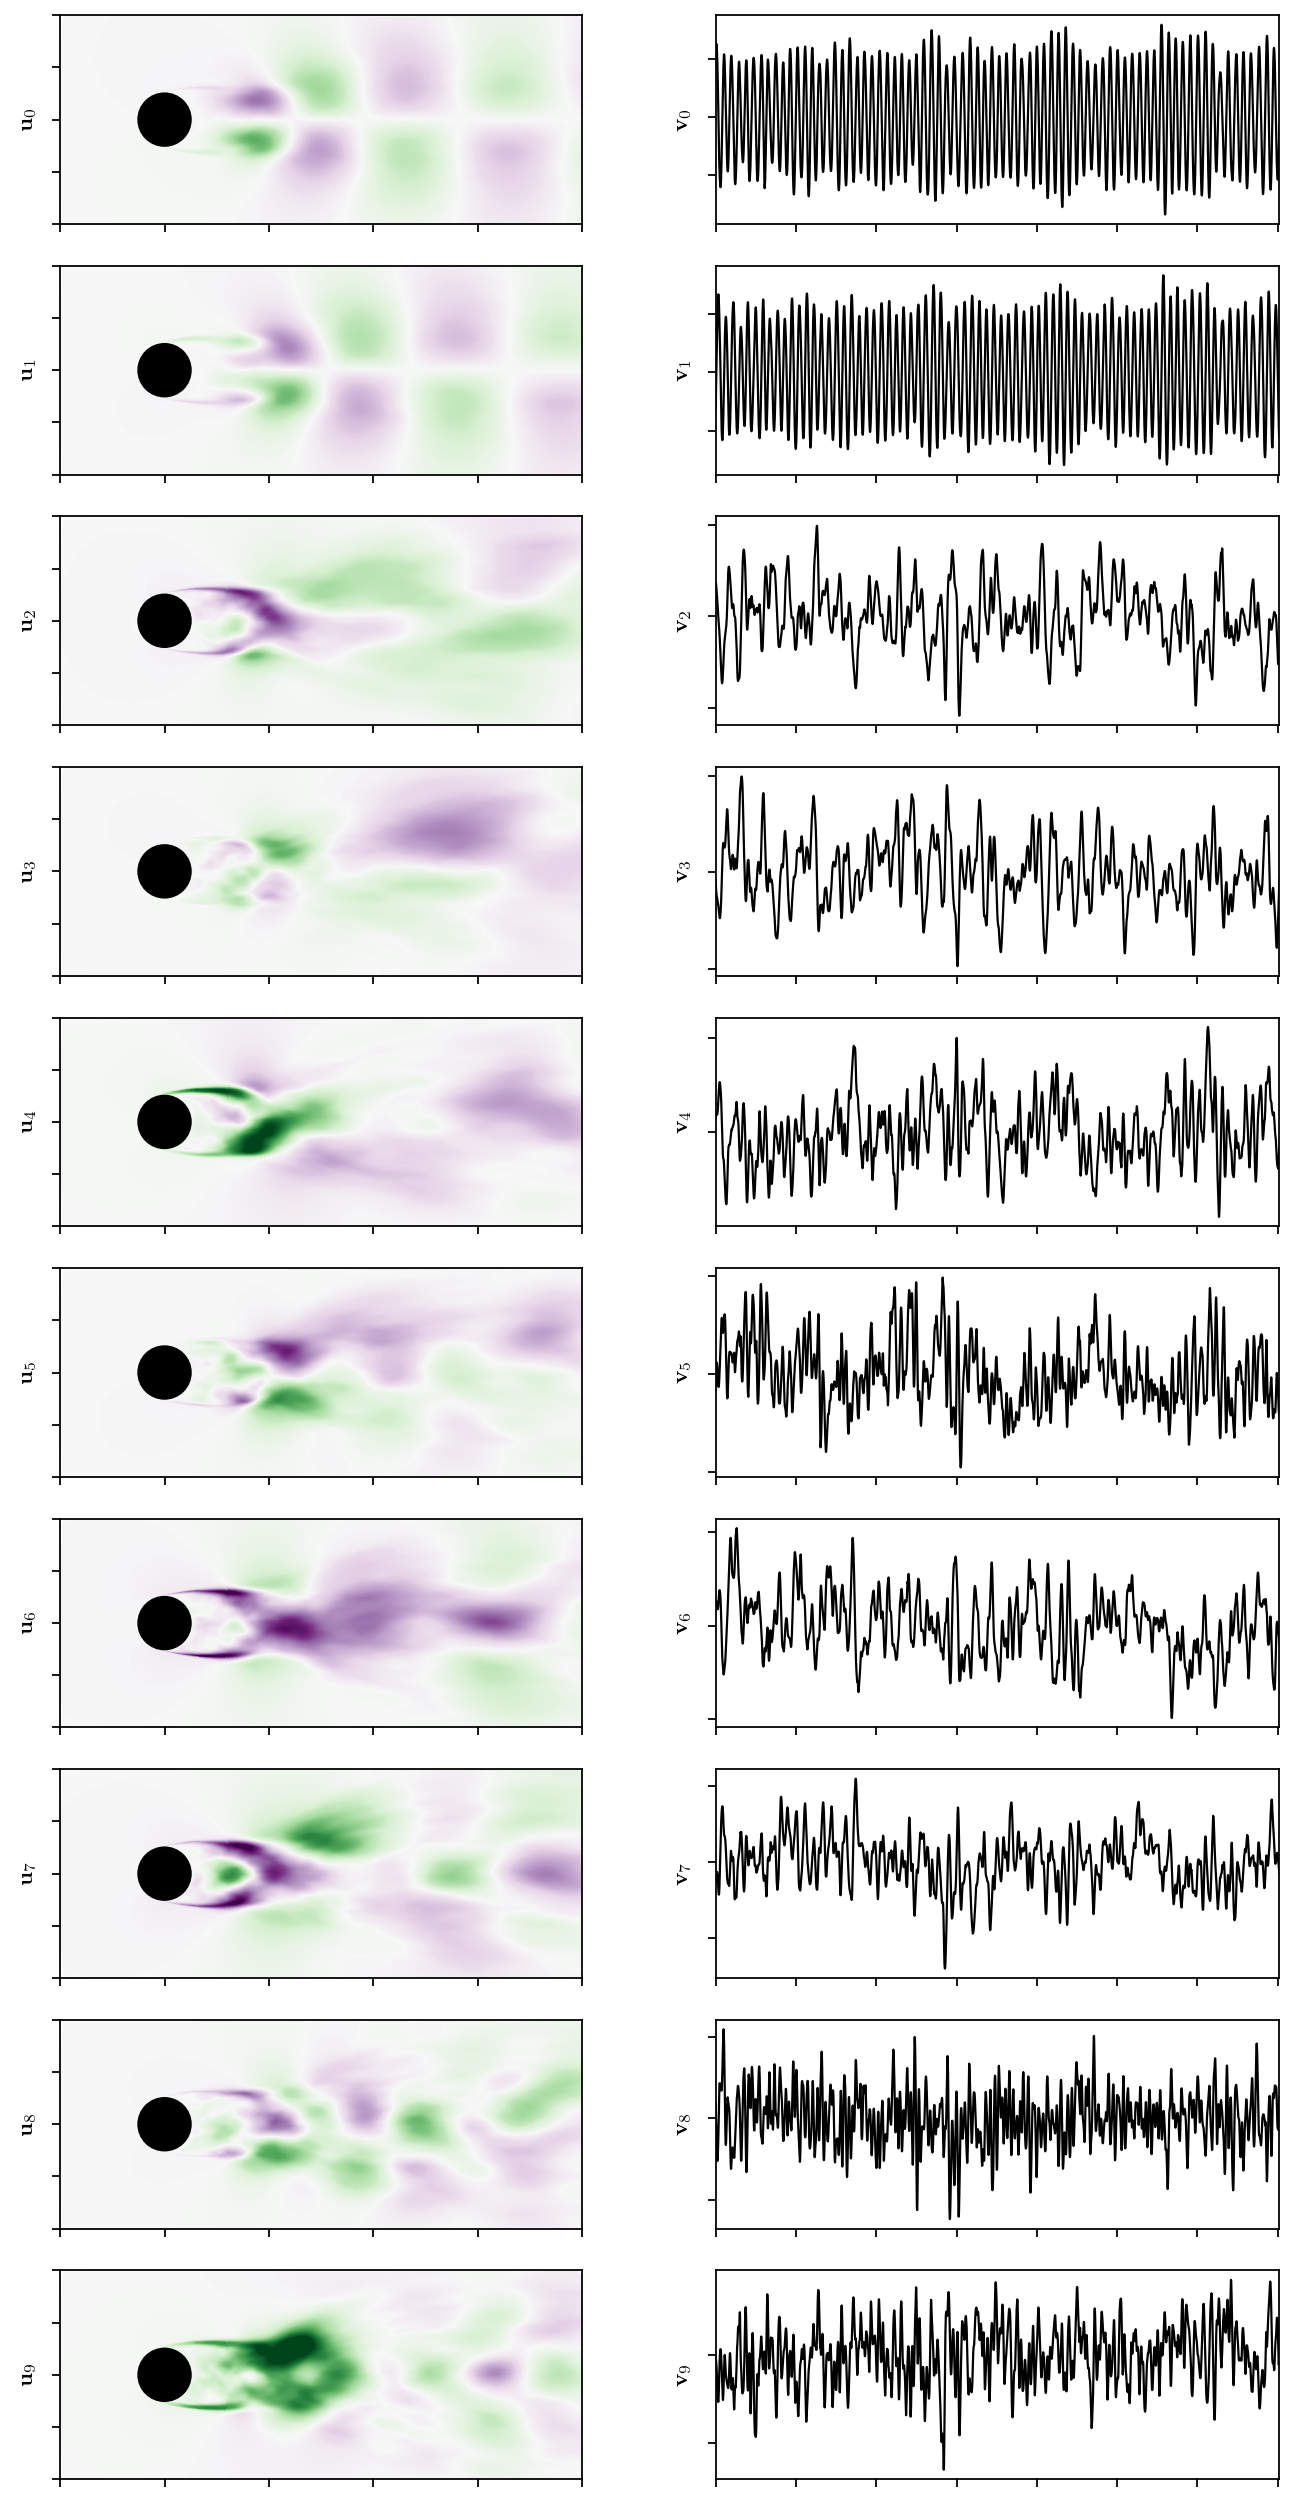

In [41]:
n_show = 10
fix, axarr = plt.subplots(n_show, 2, figsize=(10, n_show*2.0), gridspec_kw={"width_ratios": [2, 2]})
for i in range(n_show):
    add_contour(axarr[i, 0], svd.U[:n_points, i]/area[mask], -2e3, 2e3, every=2)
    axarr[i, 0].set_ylabel(rf"$\mathbf{{u}}_{i:1d}$")
    axarr[i, 1].plot(times/T_REF, svd.V[:, i], c="k", lw=1)
    axarr[i, 1].set_xlim(0, times[-1]/T_REF)
    axarr[i, 1].set_yticklabels([])
    axarr[i, 1].set_ylabel(rf"$\mathbf{{v}}_{i:1d}$")
    axarr[i, 0].set_xticklabels([])
    axarr[i, 1].set_xticklabels([])
plt.show()

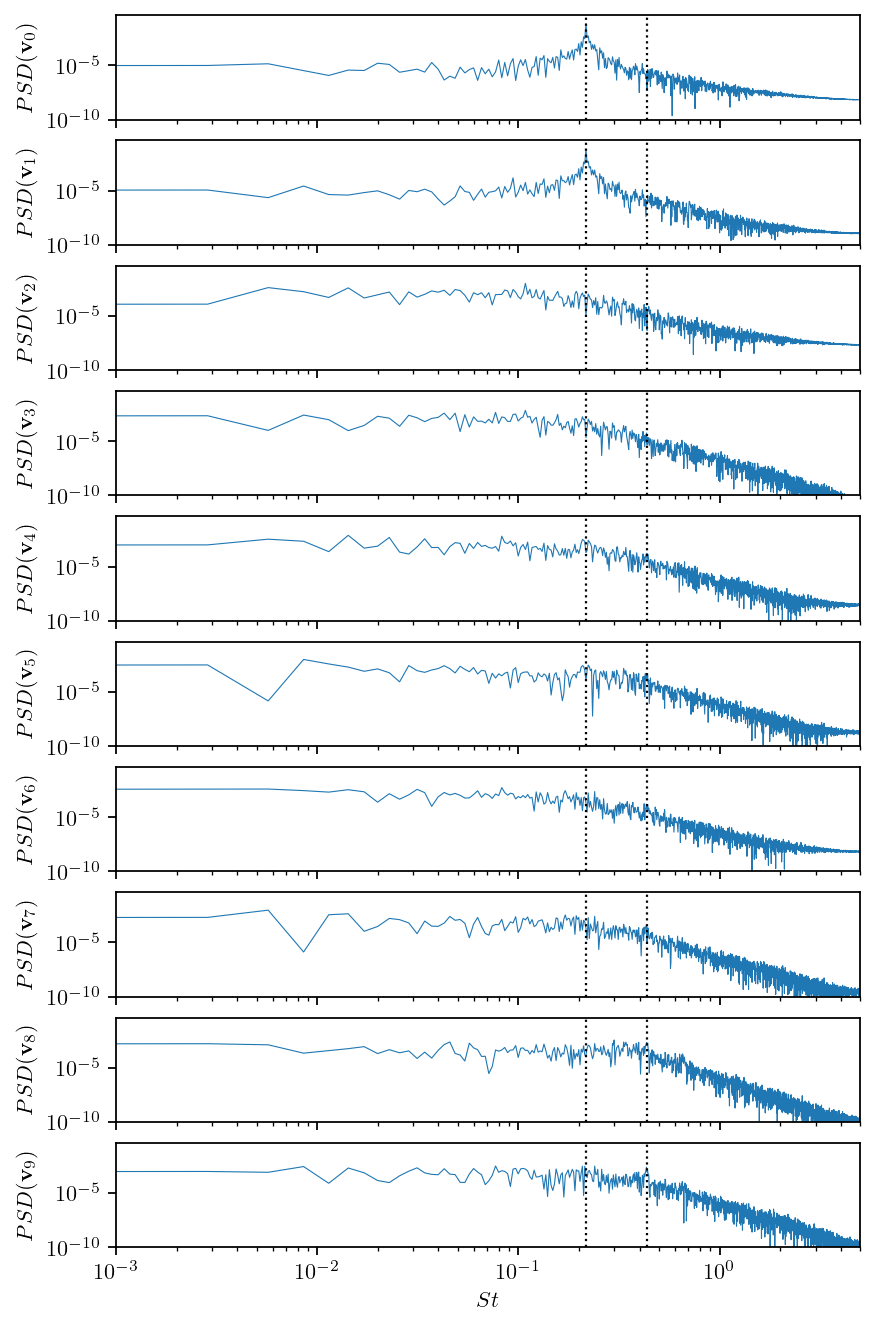

In [44]:
fig, axarr = plt.subplots(n_show, figsize=(6, 1.0*n_show), sharex=True, sharey=True)

fs = 1.0 / (times[1] - times[0])
for i in range(n_show):
    v = svd.V[:, i].numpy()
    f, psd = welch(v, fs=fs.item(), window="boxcar", nperseg=len(v), nfft=len(v))
    axarr[i].plot(f*T_REF, psd/T_REF, lw=0.5)
    axarr[i].set_ylabel(rf"$PSD(\mathbf{{v}}_{i})$")
    axarr[i].set_xscale("log")
    axarr[i].set_yscale("log")
    axarr[i].axvline(0.217, ls=":", c="k", lw=1)
    axarr[i].axvline(2*0.217, ls=":", c="k", lw=1)
    axarr[i].set_xlim(1e-3, 5)
    axarr[i].set_ylim(1e-10)
axarr[-1].set_xlabel(r"$St$")
plt.show()

In [45]:
rank = 10
dm_red = svd.U[:, :rank].T @ dm
dm_norm = ((dm_red - dm_red.min()) / (dm_red.max() - dm_red.min()) - 0.5) * 2
dm_norm.shape

torch.Size([10, 3601])

In [52]:
device = "cuda" if pt.cuda.is_available() else "cpu"
device

'cpu'

In [47]:
t_conv = times / T_REF
idx_train_start = 0
idx_train_end = bisect_left(t_conv.tolist(), 150)
idx_test_start = idx_train_end
idx_test_end = min(2 * idx_test_start, dm_norm.shape[1])
dm_train = dm_norm[:, idx_train_start:idx_train_end]
dm_test = dm_norm[:, idx_test_start:idx_test_end]
dm_train.shape, dm_test.shape

(torch.Size([10, 1539]), torch.Size([10, 1539]))

In [48]:
dt = times[1] - times[0]
dmd = DMD(dm_train, dt=dt, rank=rank)

In [49]:
cdmd = DMD(dm_train, dt=dt, rank=rank, forward_backward=True)

In [50]:
odmd = BOPDMD(svd_rank=rank, num_trials=0,
              eig_constraints={"conjugate_pairs"},
              varpro_opts_dict={"verbose": True, "use_fulljac" : True}
)
t_train = (times[idx_train_start:idx_train_end] - times[idx_train_start]).numpy()
dt = t_train[1] - t_train[0]
odmd.fit(dm_train.numpy(), t_train)

INFO:root:Snapshots: (10, 1539), snapshot shape: (10,)


Step 1 Error 0.970299554298138 Lambda 0.3333333333333333
Step 2 Error 0.9362935094232192 Lambda 0.1111111111111111
Step 3 Error 0.8670488216397549 Lambda 0.037037037037037035
Step 4 Error 0.8655198443460312 Lambda 0.5925925925925926
Step 5 Error 0.7949774007453732 Lambda 0.19753086419753085
Step 6 Error 0.5790632546931214 Lambda 0.06584362139917695
Step 7 Error 0.5584185629521566 Lambda 0.06583404496460324
Step 8 Error 0.5584185629521565 Lambda 35344383.76079555
Stall detected: error reduced by less than 1e-12 times the error at the previous step. Iteration 8. Current error 0.5584185629521565. Consider increasing tol or decreasing eps_stall.


/home/andre/Development/PyDMD/pydmd/bopdmd.py:752: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [139]:
# set the training horizon to roughly 2 vortex shedding cycles
h = int(2/0.217*T_REF*fs)
h

94

In [140]:
dt = times[1] - times[0]
ocdmd = LinearModel(dm_train, dt, decompose_operator=True, rank=rank, init_forward_backward=False)
ocdmd.train(
    1000,
    split_options={
        "horizon" : h,
        "n_shift" : 1,
        "train_size" : 0.8,
        "test_size" : 0.2,
        "forward_backward" : True
    },
    stopping_options={"checkpoint" : "/tmp/best_model.pt"},
    optimizer_options={"lr" : 1.0e-3},
    loss_key="val_loss",
    device=device
)
ocdmd.load_state_dict(pt.load("/tmp/best_model.pt", weights_only=True))

Optimization started
Epoch   69 - train loss: 1.027301e-01, val loss: 1.466636e-01, lr: 5.000000e-04Optimization completed


<All keys matched successfully>

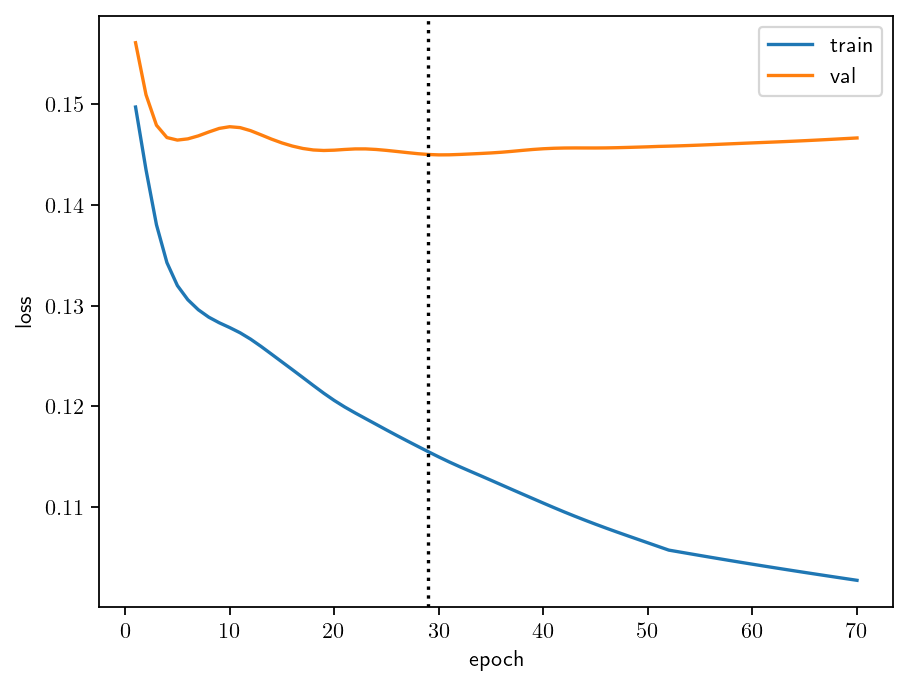

In [141]:
log = ocdmd.log
e = list(range(1, len(log["train_loss"]) + 1))
plt.plot(e, log["train_loss"], label="train")
plt.plot(e, log["val_loss"], label="val")
idx_best = np.argmin(np.array(log["val_loss"]))
plt.axvline(idx_best, ls=":", c="k")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [142]:
def evaluate_model_predictions(dm_test):
    err_pred, err_std = [], []
    norm = dm_test.norm()
    std, std_norm = dm_test.std(dim=1), dm_test.std(dim=1).norm()
    for model in (dmd, cdmd, ocdmd):
        pred = model.predict(dm_test[:, 0], dm_test.shape[1]-1)
        err_pred.append((pred - dm_test).norm() / norm)
        err_std.append((pred.std(dim=1)-std).norm() / std_norm)
    # optimized DMD
    eigvals = pt.exp(pt.from_numpy(odmd.eigs)*dt)
    b = pt.linalg.pinv(pt.from_numpy(odmd.modes)) @ dm_test[:, 0].type(eigvals.dtype)
    pred = pt.from_numpy(odmd.modes) @ (pt.linalg.vander(eigvals, N=dm_test.size(1)) * b.unsqueeze(-1))
    err_pred.append((pred - dm_test).norm() / norm)
    err_std.append((pred.std(dim=1)-std).norm()/std_norm)
    return err_pred, err_std

In [143]:
def evaluate_test_error(dm_test, n_predict, n_shift):
    err = []
    n_times = dm_test.shape[1]
    for i_start in range(0, n_times-n_predict+1, n_shift):
        i_end = min(i_start+n_predict, n_times)
        err.append(
            evaluate_model_predictions(dm_test[:, i_start:i_end])
        )
    return err

In [144]:
# predict roughly 10 vortex shedding cycles
n_predict = int(10/0.217*T_REF*fs)
test_error = pt.tensor(evaluate_test_error(dm_test, n_predict, 1))
test_error_pred = (
    test_error[:, 0, 0], test_error[:, 0, 1], test_error[:, 0, 3], test_error[:, 0, 2]
)
test_error_std = (
    test_error[:, 1, 0], test_error[:, 1, 1], test_error[:, 1, 3], test_error[:, 1, 2]
)

In [156]:
pred_err_mean = pt.tensor([e.mean(dim=0).item() for e in test_error_pred])
pred_err_mean / pred_err_mean.min()

tensor([ 1.3364,  1.9686, 88.9072,  1.0000])

In [158]:
std_err_mean = pt.tensor([e.mean(dim=0).item() for e in test_error_std])
std_err_mean / std_err_mean.min()

tensor([  1.7448,   1.4225, 339.4402,   1.0000])

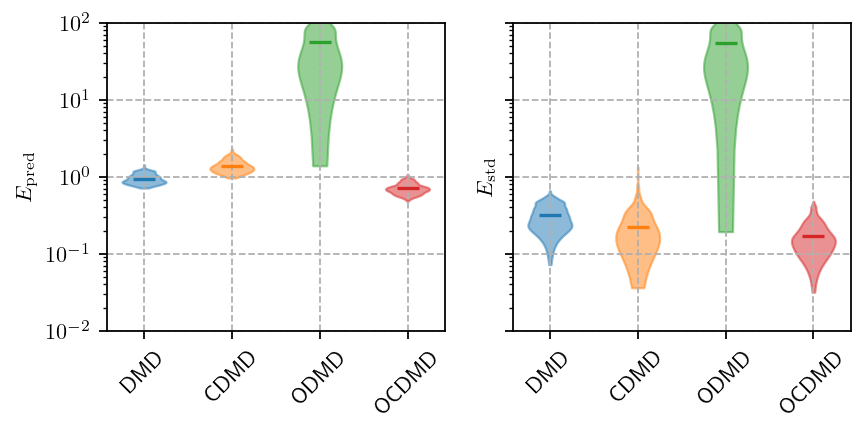

In [146]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True, sharey=True)

labels = ("DMD", "CDMD", "ODMD", "OCDMD")
x_pos = list(range(1, len(labels)+1))
for i in range(len(labels)):
    parts = ax1.violinplot(test_error_pred[i], [x_pos[i]], showmeans=False, showmedians=True, showextrema=False, widths=0.5)
    for pc in parts["bodies"]:
        pc.set_facecolor(f"C{i}")
        pc.set_edgecolor(f"C{i}")
        pc.set_alpha(0.5)
    parts = ax2.violinplot(test_error_std[i], [x_pos[i]], showmeans=False, showmedians=True, showextrema=False, widths=0.5)
    for pc in parts["bodies"]:
        pc.set_facecolor(f"C{i}")
        pc.set_edgecolor(f"C{i}")
        pc.set_alpha(0.5)
ax1.set_yscale("log")
ax1.set_ylim(0.01, 100)
ax1.set_xticks(range(1, 5))
ax1.set_xticklabels(labels, rotation=45)
ax2.set_xticklabels(labels, rotation=45)
ax1.grid(ls="--")
ax2.grid(ls="--")
ax1.set_ylabel(r"$E_\mathrm{pred}$")
ax2.set_ylabel(r"$E_\mathrm{std}$")
plt.savefig(join(output, "test_models_comparative.png"), dpi=640, bbox_inches="tight")